## Experience of determine kappa coefficient smv and random forest vs ground truth

This notebook is used to determine the kappa coefficient of the smv and random forest models vs the ground truth.

In [87]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import sys
sys.path.append('../Library')
import breedManip as breedManip
import dataProcessing as dataProcessing
import breeds as breeds
import splitData as splitData

import pickle
import os

#### Prepare the dataframe

We will build a dataframe with the feature to compute the random forest prediction, the rawState who represent the svm result and add a column with the ground truth.

In [88]:
with open('/home/magali.egger/shared-projects/mice_UNIL/Data/rfc_best.pkl', 'rb') as f:
    rfc = pickle.load(f)

In [89]:
with open('/home/magali.egger/shared-projects/mice_UNIL/Data/df_simplify_labels.pkl', 'rb') as f:
    df = pickle.load(f)

In [90]:
wierd_labels = ['8', 's', 'a', 'j', '1', '2', '3']
df = df[~df['label'].isin(wierd_labels)]

In [91]:
df = df[df['day'] == 0]

#### Prepare the random forest prediction

In [92]:
df = df.drop(columns=['mouse'])
df = df.drop(columns=['breed'])

In [93]:
features = df.drop(columns=['state', 'rawState', 'label'])

with open('/home/magali.egger/shared-projects/mice_UNIL/Data/scaler_best.pkl', 'rb') as f:
   scaler = pickle.load(f)

features = scaler.transform(features)

In [94]:
prediction = rfc.predict(features)
pred = np.argmax(prediction, axis=1)

In [95]:
pred = pred.tolist()

print(pred.count(0))
print(pred.count(1))
print(pred.count(2))

366272
19653
376708


#### Prepare the smv prediction

In [96]:
def convert(states):
    res = []
    for state in states:
        if state == 'n' or state == '5' or state=='2':
            res.append(0)
        elif state == 'r' or state=='6' or state=='3':
            res.append(1)
        elif state == 'w' or state=='4' or state=='1' or state=='9':
            res.append(2)
    return res

In [97]:
svm_labels = df['rawState']
svm = convert(svm_labels)

In [98]:
print(svm.count(0))
print(svm.count(1))
print(svm.count(2))

358102
46302
358229


#### Prepare the ground truth

In [99]:
df['label'].value_counts()

w    364982
n    351100
r     44320
5      1418
4       446
9       241
6       126
Name: label, dtype: int64

The labels 8 doesn't mean anything, we will remove them.

In [100]:
gt_labels = df['label']
gt = convert(df['label'])

In [101]:
print(gt.count(0))
print(gt.count(1))
print(gt.count(2))

352518
44446
365669


#### Comparaison SVM vs ground truth

In [102]:
# kappa coefficient
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(gt, svm)

0.8661135447393773

[[331526   4561  16431]
 [  4227  36471   3748]
 [ 22349   5270 338050]]


              precision    recall  f1-score   support

           n       0.93      0.94      0.93    352518
           r       0.79      0.82      0.80     44446
           w       0.94      0.92      0.93    365669

    accuracy                           0.93    762633
   macro avg       0.89      0.90      0.89    762633
weighted avg       0.93      0.93      0.93    762633



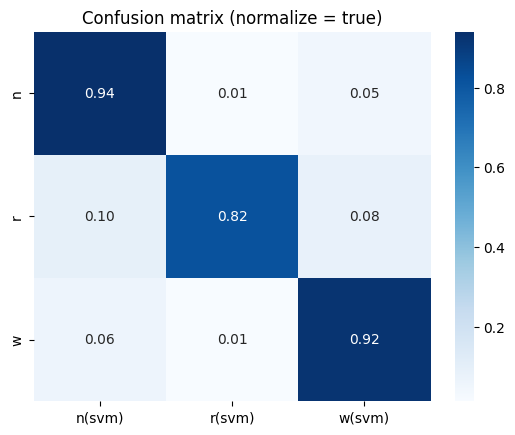

In [103]:
cm = np.array(confusion_matrix(gt, svm))
print(cm)

cm = np.array(confusion_matrix(gt, svm, normalize='true')) 
confusion = pd.DataFrame(cm, index=['n','r','w'], columns=['n(svm)','r(svm)','w(svm)'])

print(classification_report(gt, svm, target_names=['n','r','w'], zero_division=0))

sns.heatmap(confusion, annot=True, cmap="Blues", fmt='.2f')
plt.title(f'Confusion matrix (normalize = true)')
plt.show()

#### Comparaison Random Forest vs ground truth

In [104]:
# kappa coefficient
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(gt, pred)

0.790245828020345

[[321769   2126  28623]
 [ 18789  16055   9602]
 [ 25714   1472 338483]]
              precision    recall  f1-score   support

           n       0.88      0.91      0.90    352518
           r       0.82      0.36      0.50     44446
           w       0.90      0.93      0.91    365669

    accuracy                           0.89    762633
   macro avg       0.86      0.73      0.77    762633
weighted avg       0.88      0.89      0.88    762633



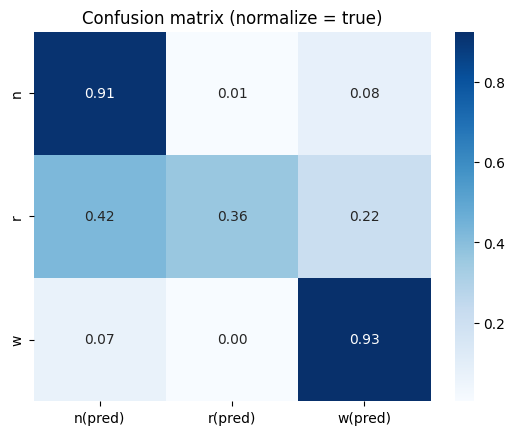

In [105]:
cm = np.array(confusion_matrix(gt, pred))
print(cm)

cm = np.array(confusion_matrix(gt, pred, normalize='true')) 
confusion = pd.DataFrame(cm, index=['n','r','w'], columns=['n(pred)','r(pred)','w(pred)'])

print(classification_report(gt, pred, target_names=['n','r','w'], zero_division=0))

sns.heatmap(confusion, annot=True, cmap="Blues", fmt='.2f')
plt.title(f'Confusion matrix (normalize = true)')
plt.show()

#### Comparaison of the balanced random forest classifier vs the svm

In [106]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(svm, pred)

0.7762054440909644

[[323010   1986  33106]
 [ 19107  15450  11745]
 [ 24155   2217 331857]]
              precision    recall  f1-score   support

           n       0.88      0.90      0.89    358102
           r       0.79      0.33      0.47     46302
           w       0.88      0.93      0.90    358229

    accuracy                           0.88    762633
   macro avg       0.85      0.72      0.75    762633
weighted avg       0.88      0.88      0.87    762633



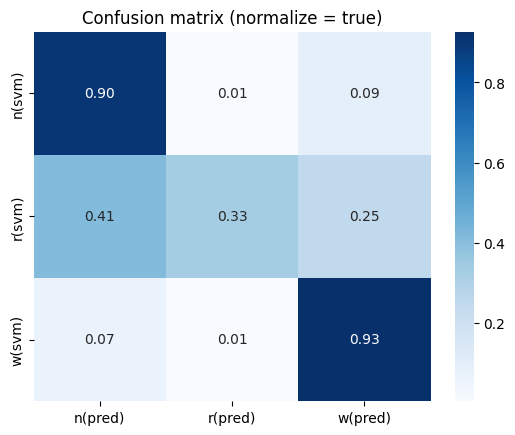

In [107]:
cm = np.array(confusion_matrix(svm, pred))
print(cm)

cm = np.array(confusion_matrix(svm, pred, normalize='true')) 
confusion = pd.DataFrame(cm, index=['n(svm)','r(svm)','w(svm)'], columns=['n(pred)','r(pred)','w(pred)'])

print(classification_report(svm, pred, target_names=['n','r','w'], zero_division=0))

sns.heatmap(confusion, annot=True, cmap="Blues", fmt='.2f')
plt.title(f'Confusion matrix (normalize = true)')
plt.show()